In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
normal = pd.read_csv('normal.csv', sep=',', header = None)
abnormal = pd.read_csv('abnormal.csv', sep=',', header = None)
scaler = MinMaxScaler()
df_scaled_abnormal = scaler.fit_transform(abnormal)
df_scaled_abnormal

array([[6.42629706e-02, 2.84623291e-02, 3.72991143e-01, ...,
        4.25701523e-02, 2.83310413e-02, 9.30774207e-02],
       [9.03149068e-02, 4.74756684e-02, 3.63818909e-01, ...,
        2.49521409e-02, 5.83178810e-02, 2.39513118e-01],
       [1.70452771e-01, 4.54761349e-02, 4.53500736e-01, ...,
        1.01528263e-01, 2.25885469e-01, 4.30588297e-01],
       ...,
       [2.77918351e-03, 7.51611360e-04, 6.89631339e-04, ...,
        1.13167895e-04, 4.24303070e-04, 2.80433942e-04],
       [2.98187555e-03, 6.52477147e-04, 5.92430793e-04, ...,
        3.44986672e-05, 6.26837662e-04, 8.35118855e-04],
       [9.44620228e-04, 2.54860886e-04, 3.86590796e-04, ...,
        9.21525891e-05, 1.44679663e-05, 4.50336122e-04]])

In [3]:
df_scaled_normal = scaler.fit_transform(normal)

In [4]:
# generate train set
# training set will consist of the normal ds
df_scaled_normal = df_scaled_normal.T
df_scaled_abnormal = df_scaled_abnormal.T
len_norm = len(df_scaled_normal)
len_norm_train = int(0.8 * len_norm)
X_train = df_scaled_normal[:len_norm_train]

# generate test set consist of 50% attack and 50% normal
X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]



X_test_norm = df_scaled_normal[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = df_scaled_abnormal[:len_attack_test]
# X_test = df_scaled_abnormal

In [ ]:
X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [11]:
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = 50

In [13]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 5001)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 2500)         12505000    ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 50)           125050      ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 50)           125050      ['dense[0][0]']                  
                                                                                            

In [14]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 2500)              127500    
                                                                 
 dense_2 (Dense)             (None, 5001)              12507501  
                                                                 
Total params: 12,635,001
Trainable params: 12,635,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [16]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [17]:
opt = optimizers.Adam(learning_rate=0.0002, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=False,
                        epochs=32,
                        batch_size=50)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 5001)]            0         
                                                                 
 encoder (Functional)        (None, 50)                12755100  
                                                                 
 decoder (Functional)        (None, 5001)              12635001  
                                                                 
Total params: 25,390,101
Trainable params: 25,390,101
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples
Epoch 1/32


2021-12-03 03:42:22.419595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:42:22.425689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-03 03:42:22.426430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-03 03:42:22.427350: I tensorflow/core/platform/cpu_f

1709/1709 [==============================] - 14s 8ms/sample - loss: 49351437464.4066
Epoch 2/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 516.3876
Epoch 3/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 162.2002
Epoch 4/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 147.1602
Epoch 5/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 138.8126
Epoch 6/32
1709/1709 [==============================] - 12s 7ms/sample - loss: 130.5856
Epoch 7/32
1709/1709 [==============================] - 12s 7ms/sample - loss: 133.2512
Epoch 8/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 127.5974
Epoch 9/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 125.5130
Epoch 10/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 124.6695
Epoch 11/32
1709/1709 [==============================] - 11s 7ms/sample - loss: 128.5913
Epoch 12/32
1709/1709 [==========

In [ ]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [19]:
X_train_pred = vae_model.predict(X_train)
X_train_pred

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[0.9112257 , 0.03776976, 0.04774925, ..., 0.01401412, 0.01512238,
        0.01134625],
       [0.9852357 , 0.01743361, 0.01820073, ..., 0.00564691, 0.00463733,
        0.00541249],
       [0.97341156, 0.03731933, 0.03903744, ..., 0.01417279, 0.01364622,
        0.01743829],
       ...,
       [0.6895642 , 0.03394476, 0.06320986, ..., 0.00960958, 0.01114959,
        0.00792131],
       [0.85242563, 0.01460278, 0.02857205, ..., 0.00354388, 0.00383729,
        0.0032953 ],
       [0.85856843, 0.04475003, 0.06251889, ..., 0.01652795, 0.01493287,
        0.01683488]], dtype=float32)

In [ ]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

In [22]:
X_pred = vae_model.predict(X_test)
X_pred

array([[8.74263167e-01, 4.94357944e-03, 9.20611620e-03, ...,
        6.01291656e-04, 8.51303339e-04, 4.08500433e-04],
       [8.27100873e-01, 1.54776573e-02, 3.04918289e-02, ...,
        4.59456444e-03, 5.28264046e-03, 3.52647901e-03],
       [5.99551797e-01, 3.19603384e-02, 5.10240197e-02, ...,
        5.26791811e-03, 8.64681602e-03, 7.34919310e-03],
       ...,
       [3.54062736e-01, 9.50121880e-02, 1.24347627e-01, ...,
        4.24041450e-02, 4.28051949e-02, 3.70397866e-02],
       [7.77161598e-01, 5.81178367e-02, 7.41798580e-02, ...,
        1.48987174e-02, 1.89921856e-02, 1.47616565e-02],
       [2.50410438e-01, 1.69551164e-01, 2.02684671e-01, ...,
        9.80975926e-02, 9.44257975e-02, 1.16768479e-01]], dtype=float32)

In [82]:
normal = np.max(X_pred[:,:len(X_test_norm)], axis =1)
abnormal = np.max(X_pred[:,len(X_test_norm):], axis = 1)
pd.DataFrame(normal).to_csv("normal.csv")
pd.DataFrame(abnormal).to_csv("abnormal.csv")

In [11]:
normal = pd.read_csv('normal.csv', sep=',', header = None)
abnormal = pd.read_csv('abnormal.csv', sep=',', header = None)

0      0.000000
1      0.874263
2      0.827101
3      0.599552
4      0.542552
         ...   
852    0.706474
853    0.892902
854    0.510111
855    0.777162
856    0.629440
Name: 1, Length: 857, dtype: float64

In [ ]:
normal_r = np.where(normal[1] > 0.45, 1, 0)
normal_r

In [ ]:
abnormal_r = np.where(abnormal[1] > 0.45, 1, 0)
abnormal_r

In [35]:
x_result = np.concatenate([normal_r, abnormal_r], axis = 0)

In [39]:
y_test = np.zeros(len(normal) + len(abnormal))
y_test[:len(normal)] = 1
y_test.shape

(1714,)

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
cm = confusion_matrix(y_test, x_result, normalize = 'true')
cm

array([[1.        , 0.        ],
       [0.00116686, 0.99883314]])

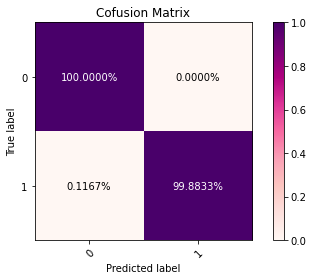

In [42]:
normalize = True
cmap = 'RdPu'
classes = [0, 1]
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.4%' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()


(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

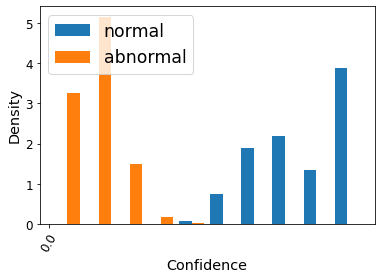

In [84]:
import math
# fig = plt.figure()
# plt.hist([np.sum(X_train_pred, axis =1),np.sum(X_pred, axis = 1)], density=True, label=['normal','abnormal'])
plt.hist([normal,abnormal], density=True, label=['normal','abnormal'])
# plt.hist([np.min(X_train_pred, axis =1),np.min(X_pred, axis = 1)], density=True, label=['normal','abnormal'])
x_min = math.floor(np.min(np.max(X_pred[:,:len(X_test_norm)], axis =1)))
x_max = math.floor(np.max(np.max(X_pred[:,len(X_test_norm):], axis = 1)))
x_plot = np.linspace(math.floor(x_min), math.floor(x_max), num=(x_max-x_min)*10+1)

plt.legend(fontsize='xx-large', loc='upper left')
#plt.ylabel('Density', rotation='horizontal', ha='right', va='center', fontsize='large')
plt.ylabel('Density', fontsize='x-large')
plt.xlabel('Confidence', fontsize='x-large')
plt.xticks(ticks=np.around(x_plot, decimals=2), labels=np.around(x_plot, decimals=2), fontsize='large', rotation=60)
plt.yticks(fontsize='large')
# fig.savefig('output.png')